In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import randint as sp_randint, uniform as sp_uniform

In [3]:
# loading train dataset

train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
train.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [4]:
# printing the shape of the train dataset

train.shape

(39211, 16)

Shape of Training Data: **(39211, 16)**

In [5]:
# loading test dataset

test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
test.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [6]:
# printing the shape of the test dataset

test.shape

(10000, 15)

Shape of test data: **(10000, 15)**

In [7]:
# spliting the dataset into feature matrix and target vector

X = train.drop(columns = ["last contact date","target"])
y = train["target"]

In [8]:
# checking for null values

X.isna().sum()

age              0
job            229
marital          0
education     1467
default          0
balance          0
housing          0
loan             0
contact      10336
duration         0
campaign         0
pdays            0
previous         0
poutcome     29451
dtype: int64

There are 4 columns which got **null values**

Columns with Null Values: *'job'*, *'education'*, *'contact'* and *'poutcome'*

In [9]:
# getting information about the columns of the feature matrix

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        39211 non-null  int64 
 1   job        38982 non-null  object
 2   marital    39211 non-null  object
 3   education  37744 non-null  object
 4   default    39211 non-null  object
 5   balance    39211 non-null  int64 
 6   housing    39211 non-null  object
 7   loan       39211 non-null  object
 8   contact    28875 non-null  object
 9   duration   39211 non-null  int64 
 10  campaign   39211 non-null  int64 
 11  pdays      39211 non-null  int64 
 12  previous   39211 non-null  int64 
 13  poutcome   9760 non-null   object
dtypes: int64(6), object(8)
memory usage: 4.2+ MB


In [10]:
# getting overall description of the feature matrix (only for numerical columns)

X.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [11]:
# label count values

y.value_counts()

target
no     33384
yes     5827
Name: count, dtype: int64

In [12]:
# label proportion values

y.value_counts(normalize = True)

target
no     0.851394
yes    0.148606
Name: proportion, dtype: float64

**from the labels it is clearly seen that the dataset is highly imbalanced**

<Axes: xlabel='target', ylabel='Count'>

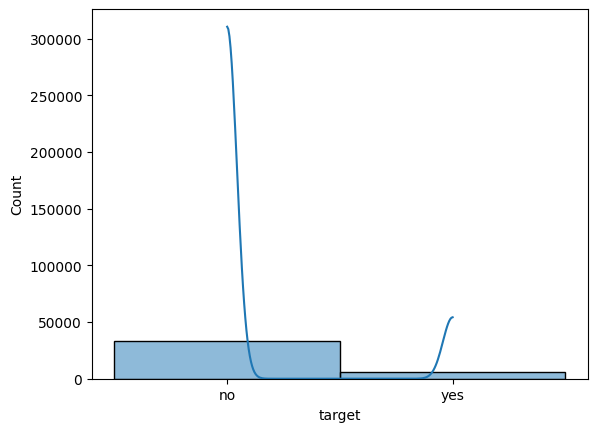

In [13]:
sns.histplot(y, bins=100, kde=True)

In [14]:
# getting the column names from the feature matrix

X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome'],
      dtype='object')

*columns available in the feature matrix of the training data*:

***['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome***']

In [15]:
# extraction of categorical as well as numerical columns from the feature matrix

num = list(X.select_dtypes(include = "int").columns)
cat = list(X.select_dtypes(exclude = "int").columns)
cat.remove('education') # column removed because it needed ordinal encoding during dummy model building
print(f"Numerical: {num}")
print(f"Categorical: {cat}")

Numerical: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
Categorical: ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']


### Observing the datset we got the insights regarding columns as follows:

- **Categorical Columns**: *'job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'education'*
- **Numerical Columns**: *'age', 'balance', 'duration', 'campaign', 'pdays', 'previous'*
- **Dropped Categorical Column for EDA but needs Feature Engineering**: *'last contact date'*
- **Target Column**: *'target'*

In [16]:
# finding unique values for 'education' column

X['education'].value_counts()

education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64

***Three categories of for the column 'education' and these values are ordinal categorical data***

In [17]:
# finding unique values for each column of the feature matrix

for col in X.columns:
    print('{} : {}'.format(col,X[col].unique()))

age : [26 52 44 33 31 25 46 37 38 32 28 34 86 42 58 39 35 47 45 48 30 50 56 54
 40 53 41 51 27 29 57 63 36 43 19 55 49 23 83 60 22 80 76 59 24 93 71 89
 64 68 85 79 62 69 20 90 66 87 72 88 67 70 77 91 78 61 65 73 74 84 82 92
 81 18 21 75 94 95]
job : ['blue-collar' 'technician' 'admin.' 'entrepreneur' 'unemployed'
 'management' 'services' 'student' 'self-employed' 'retired' 'housemaid'
 nan]
marital : ['married' 'single' 'divorced']
education : ['secondary' 'tertiary' 'primary' nan]
default : ['no' 'yes']
balance : [  647   553  1397 ...  4307  6187 38594]
housing : ['yes' 'no']
loan : ['no' 'yes']
contact : ['cellular' 'telephone' nan]
duration : [ 357  160  326 ... 3506 4144 1631]
campaign : [ 2  1  3  4  6 45  5 44 12 61 58  7  8 20 43 17 13 15 48 34 11 54 22 26
 29 21 10 49  9 52 53 57 16 50 46 47 23 37 18 38 32 36 39 56 14 30 41 63
 51 28 25 62 55 42 35 31 59 19 40 33 24 27 60]
pdays : [331  -1 852 661 152 599 365 367 238 129 287 174 120 368 371 187 610 364
 633  80 125 356 248 18

In [18]:
# replacing '?' values by NaN

for col in X.columns:
    X[col].replace({'?':np.nan},inplace=True)

X.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN
2,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN
3,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN
4,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN


**if any column had any '?' value then it has been removed now**

<Axes: >

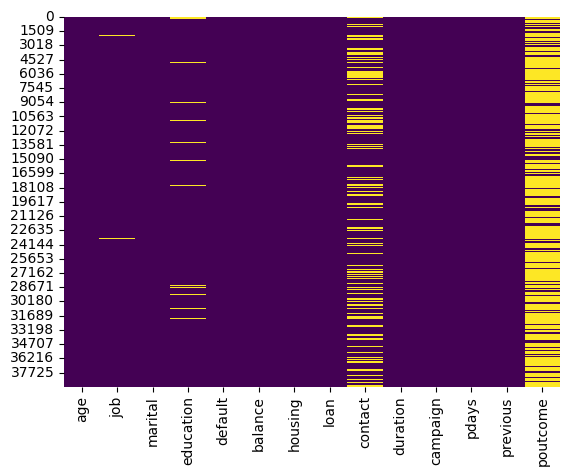

In [19]:
# heatmap to see which column has highest null values

sns.heatmap(X.isnull(),cbar=False,cmap='viridis')

from the above plot it is seen that the column 'poutcome' has **the highest number of missing values** followed by 'contact' then 'education' and at last 'job'

In [20]:
# replacing values with the most frequent values for the given categorical columns

num_col = ['job', 'education',  'contact', 'poutcome']
for col in num_col:
    # X[col]=pd.to_numeric(X[col])
    X[col].fillna(X[col].mode()[0], inplace=True)
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,failure
2,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,failure
3,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,failure
4,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,failure


In [21]:
X.age.value_counts(ascending=False)

age
32    1688
31    1629
33    1599
35    1571
34    1566
      ... 
18      44
92      41
87      40
85      39
95       2
Name: count, Length: 78, dtype: int64

<Axes: xlabel='age', ylabel='Count'>

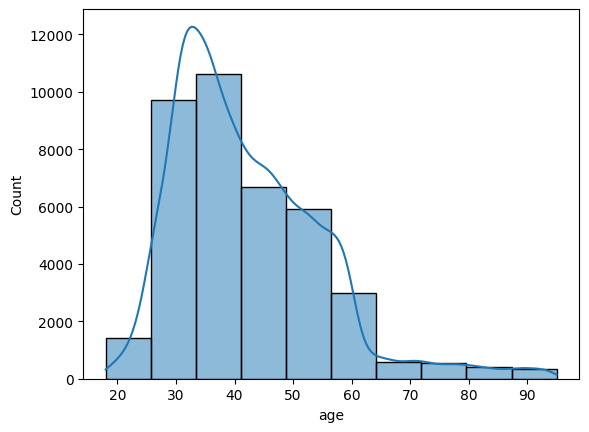

In [22]:
# binning the 'age' column

sns.histplot(X.age,bins = 10, kde=True, edgecolor='black')

In [23]:
# finding unique values for the 'balance' column

X.balance.value_counts(ascending=False)

balance
0        2799
1         149
2         122
4         115
3         104
         ... 
95094       1
81074       1
31565       1
5278        1
38594       1
Name: count, Length: 9535, dtype: int64

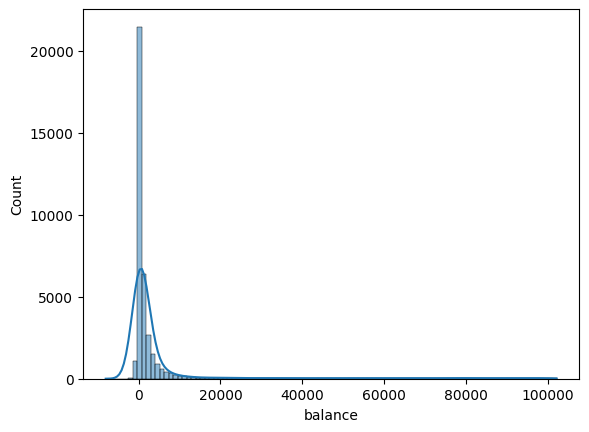

In [24]:
# binning the balance column

sns.histplot(train['balance'], bins=100, kde=True, edgecolor='black')
plt.show()

*around 0 there is a peak and there are around 2799 values in the train data having zero balance*

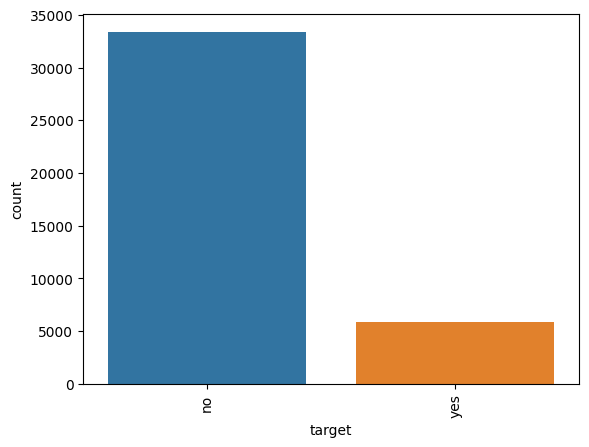

target
no     33384
yes     5827
Name: count, dtype: int64

In [25]:
# bar chart plot on the basis of the count of the labels

sns.countplot(data = train, x='target')
plt.xticks(rotation=90)
plt.show()

train['target'].value_counts()

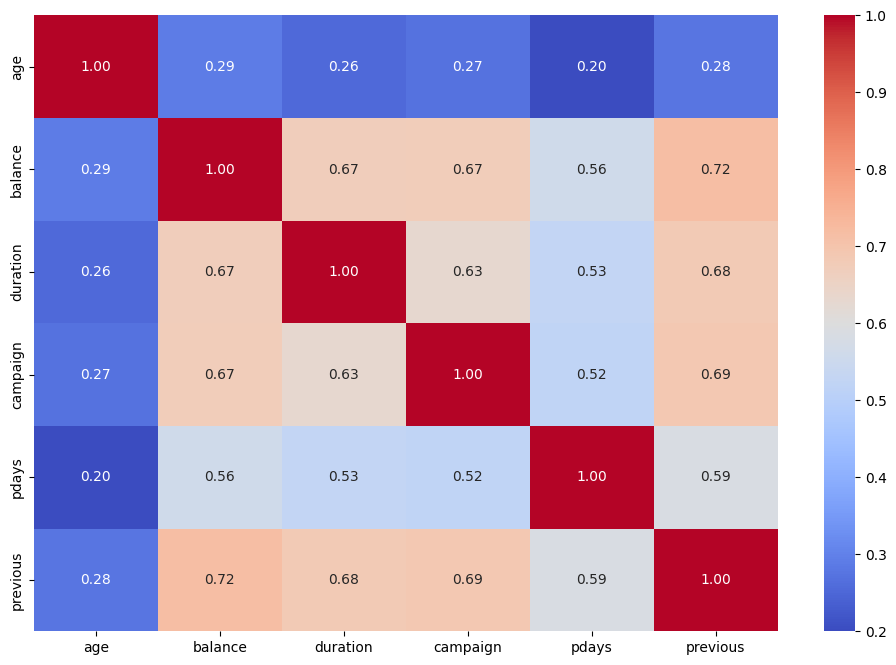

In [26]:
# HeatMap Plotting

# Select only numerical columns
numerical = X.select_dtypes(include=['float64', 'int64'])

# Handle missing values in numerical columns, e.g., fill with the mean
numerical = numerical.fillna(numerical.mean())

# Compute the correlation matrix
corr = numerical.corr()

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

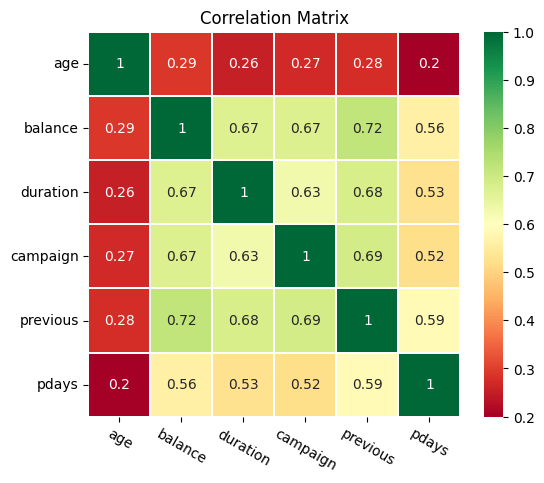

In [27]:
# correlation matrix

corr_data = X[['age','balance','duration','campaign','previous','pdays']]
corr = corr_data.corr()
cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

#### *From the correlation matrix it can be seen that, 'previous' and 'balance' have **strong positive correlation**, as well as previous with both 'duration' and 'campaign', whereas there is almost **weak positive correlation** in between 'age' and all the other numerical columns*

#### *'balance has **positive correlation** with both the columns 'duration' and 'campaign'*

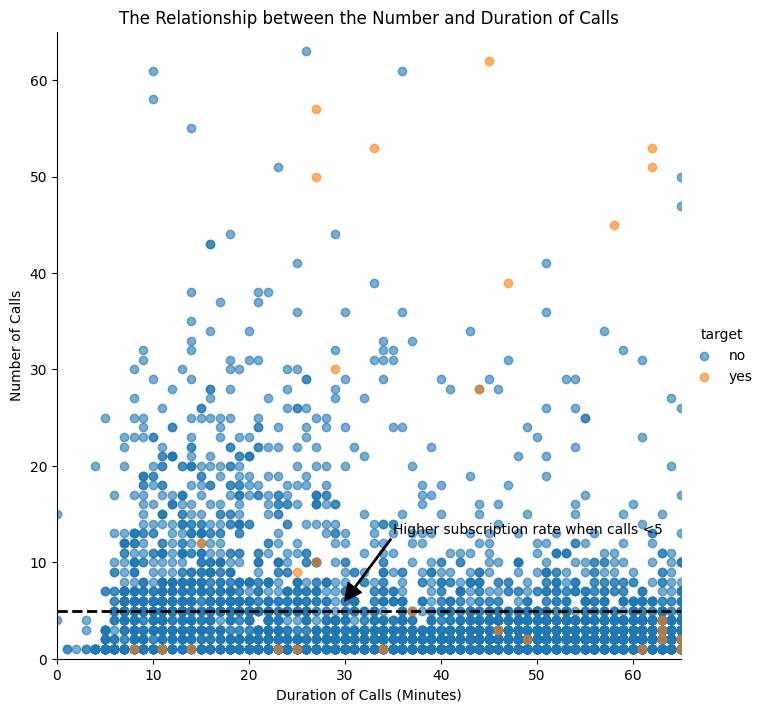

In [28]:
# density plot

dur_cam = sns.lmplot(x='duration', y='campaign',data = train,
                     hue = 'target',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

***It is seen that subscription rate is higher when number of calls are less than 5***

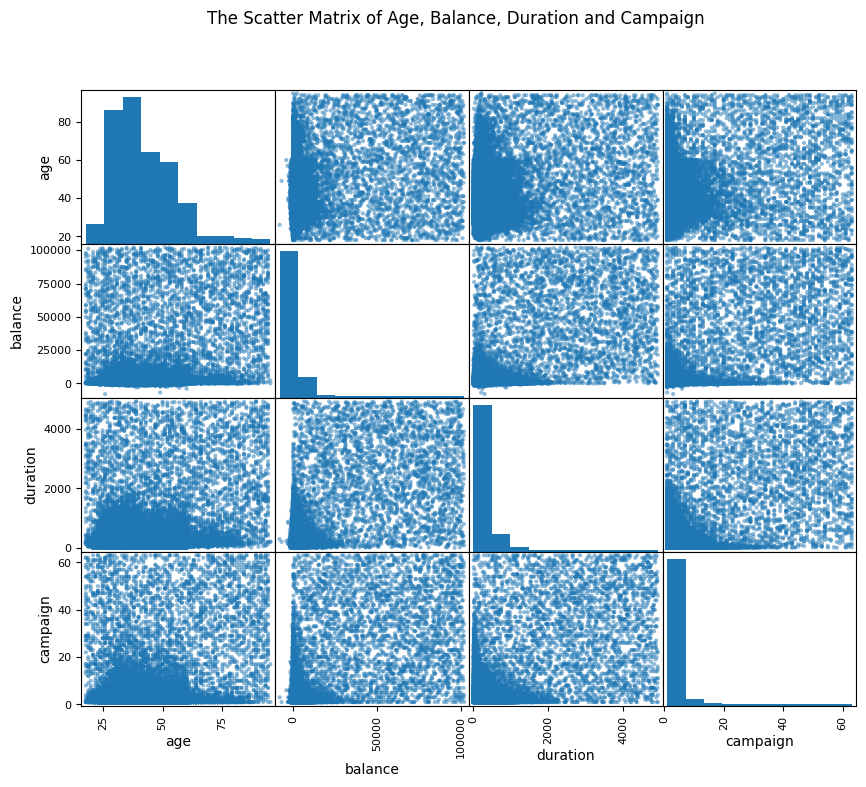

In [29]:
# Scatter Plot

from pandas.plotting import scatter_matrix

matrix = scatter_matrix(train[['age','balance','duration','campaign']],figsize=(10,8))

plt.suptitle('The Scatter Matrix of Age, Balance, Duration and Campaign')
plt.show()

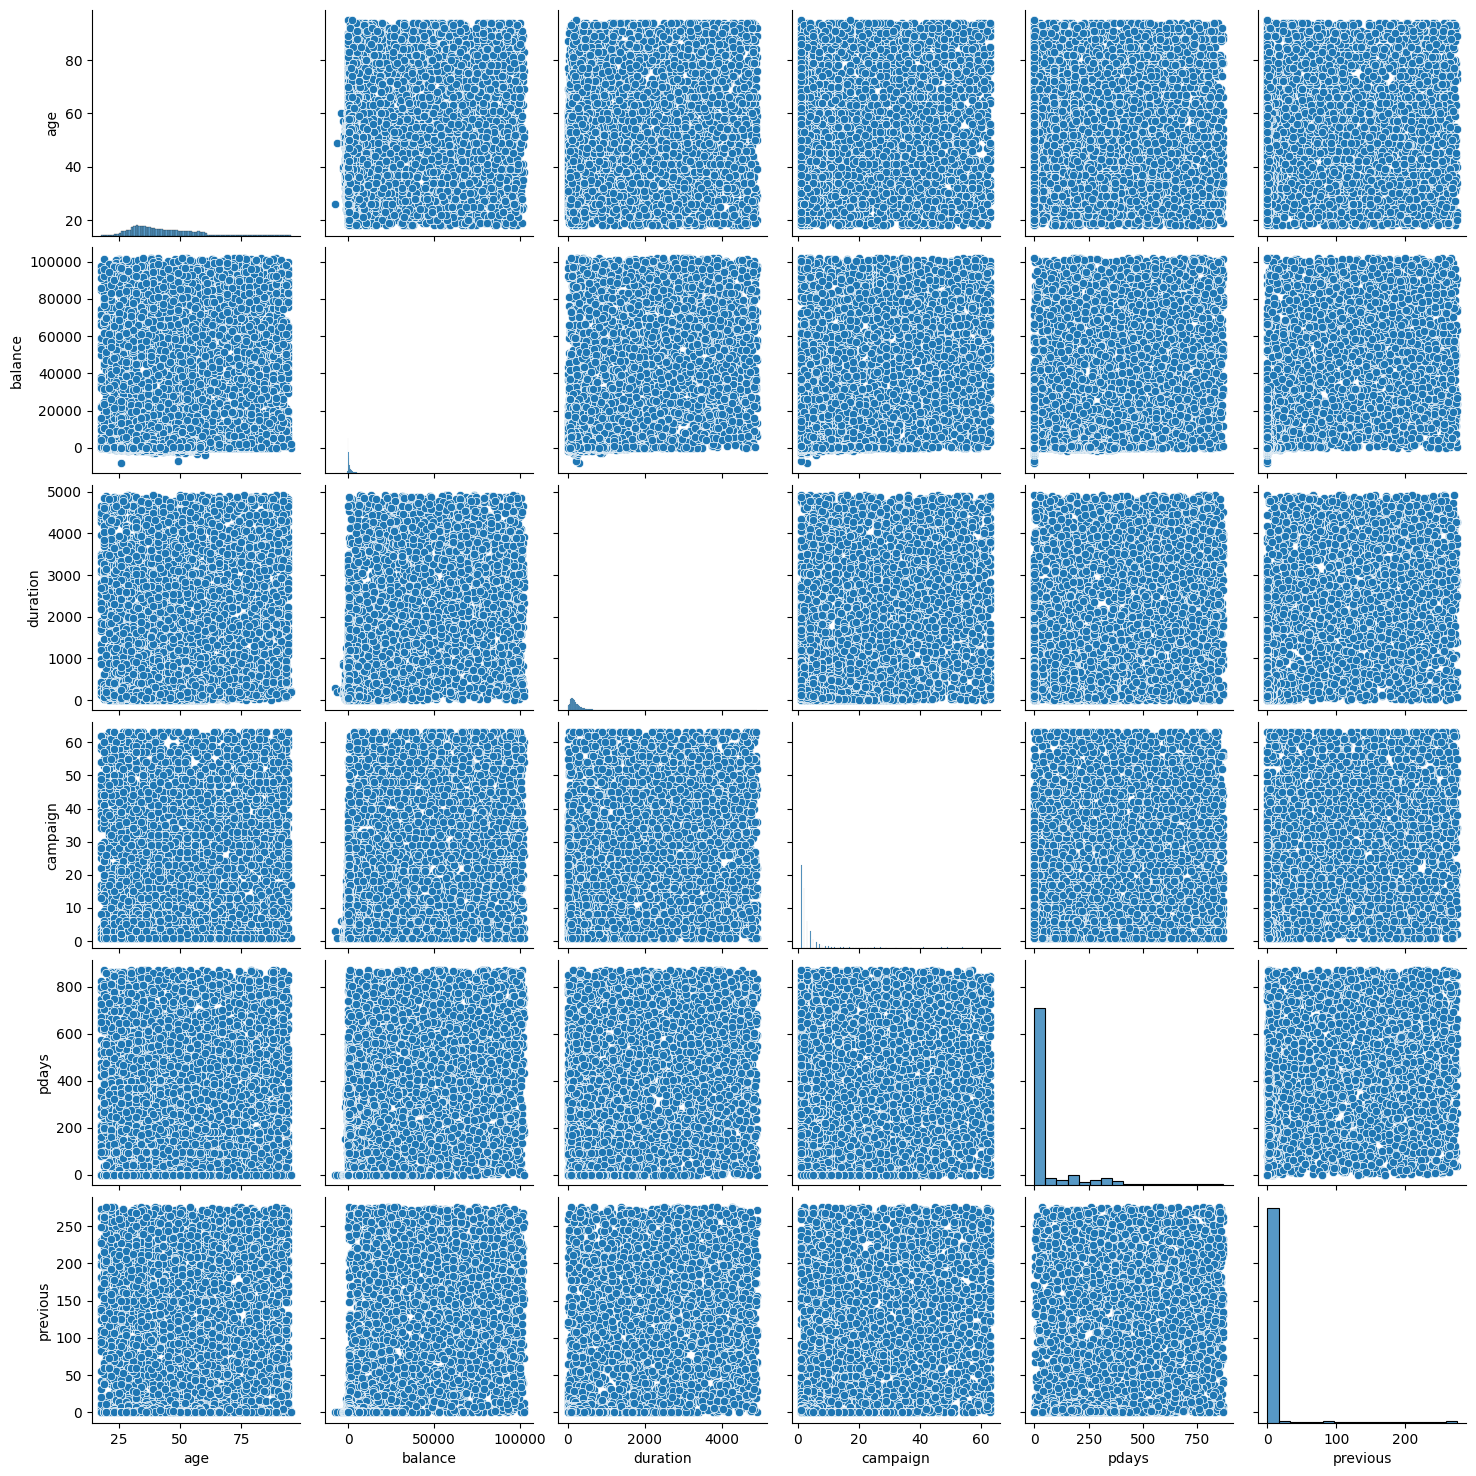

In [30]:
# Pair Plot

# Selecting the relevant numerical columns for pair plotting
numerical_data = train[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']]

# Plotting pair plots to visualize the relationships
sns.pairplot(numerical_data)
plt.show()

In [31]:
train['duration'].value_counts(ascending=False)

duration
124     162
114     149
90      145
139     145
89      145
       ... 
2303      1
3808      1
1299      1
2054      1
1631      1
Name: count, Length: 3146, dtype: int64

<Axes: xlabel='duration', ylabel='Count'>

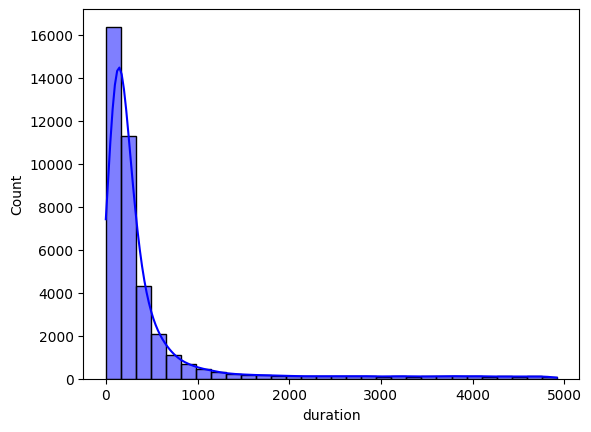

In [32]:
# hustogram for the column 'duration'

sns.histplot(train['duration'], bins=30, edgecolor='black', kde=True, color='Blue')

In [33]:
train['campaign'].value_counts(ascending=False)

campaign
1     14013
2     10016
3      4470
4      2861
5      1469
      ...  
48       44
30       43
40       43
60       43
53       38
Name: count, Length: 63, dtype: int64

<Axes: xlabel='campaign', ylabel='Count'>

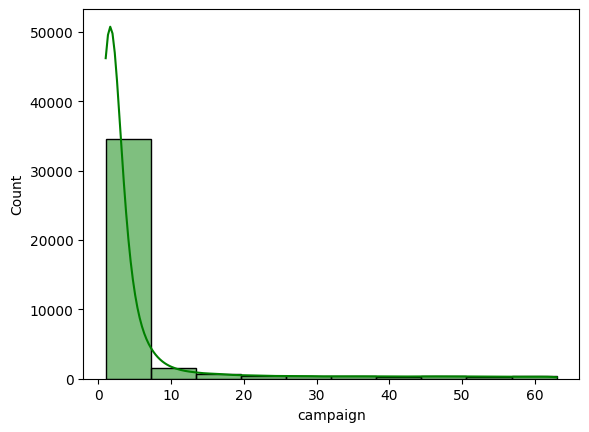

In [34]:
# binning the campaign column

sns.histplot(train['campaign'],bins=10, edgecolor='black', color='green', kde=True)

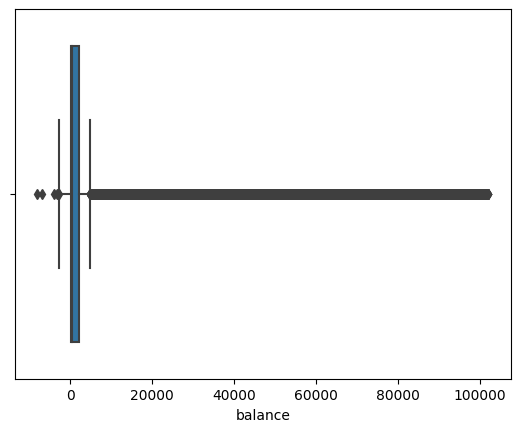

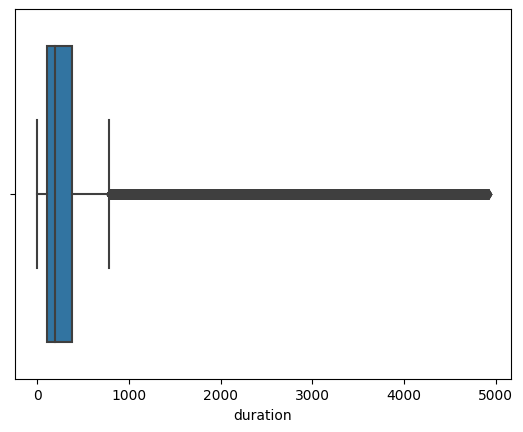

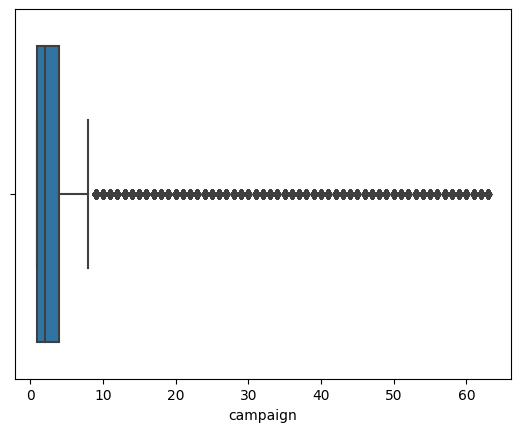

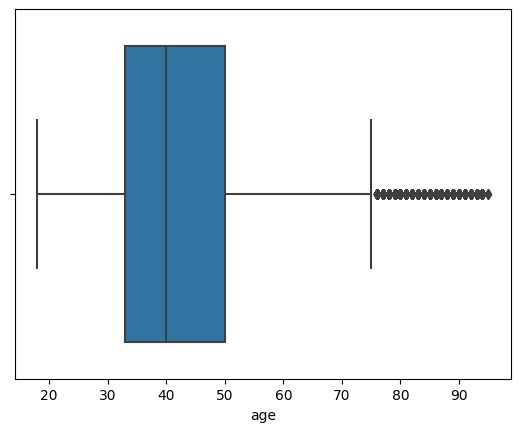

In [35]:
# Boxplot for the numerical columns

sns.boxplot(x=train['balance'])
plt.show()

sns.boxplot(x=train['duration'])
plt.show()

sns.boxplot(x=train['campaign'])
plt.show()

sns.boxplot(x=train['age'])
plt.show()

# **Dummy Model**

In [36]:
# # dummy column transformation approach using pipeline & column transformer

# scale = Pipeline(steps = [
#     ("std", StandardScaler())
# ])

# mode_ohe = Pipeline(steps = [
#     ("mode", SimpleImputer(strategy = "most_frequent")),
#     ("ohe", OneHotEncoder(sparse_output = False))
# ])

# mode_ordinal = Pipeline(steps = [('mode',SimpleImputer(strategy = 'most_frequent')),
#                        ('ordinal', OrdinalEncoder(categories = [['primary', 'secondary', 'tertiary']], 
#                                                   handle_unknown='use_encoded_value', unknown_value=-1))])

# ct = ColumnTransformer(transformers = [
#     ("scale", scale, num),
#     ("mode_ohe", mode_ohe, cat),
#     ("mode_ordinal", mode_ordinal, ['education'])
# ],remainder = "passthrough").set_output(transform = "pandas")


# # Train Test Split Step
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, 
#                                                   random_state = 42, stratify = y)

# # Transformation of train and test data
# X_train_df = ct.fit_transform(X_train)
# X_val_df = ct.transform(X_val)

# # dummy random forrest model definition
# rfc = RandomForestClassifier(random_state = 42, oob_score = True, class_weight = 'balanced')

# rfc.fit(X_train_df, y_train) # fitting the training data to the model

# y_pred_rfc = rfc.predict(X_val_df) # prediction on the validation set

# score_rfc = f1_score(y_val, y_pred_rfc, average = "macro", labels = 'yes') # calculation f1 macro score

# print(f"f1_score for RandomForestClassifier: {score_rfc}")

## ***GridSearchCV on dummy RFC model***

In [37]:
# # dummy GridSearchCV approach for the above RFC model

# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {
#     'n_estimators': [50, 100, 200, 500],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
#     }
# ]

# # GridSearchCV definition

# gscv_rf = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, 
#                        verbose = 3, n_jobs = -1, scoring = 'f1_macro')


# gscv_rf.fit(X_train_df, y_train) # fitting the train data on to the GridSearchCV

# # finding the best estimator

# print(f"Best Estimators for Random Forest by GridSearchCV: {gscv_rf.best_estimator_}")

# gscv_rf_pred = gscv_rf.predict(X_val_df) # predition stage on validation data

# # f1 score calculation

# print(f"f1 score for Random Forest by GridSearchCV: {f1_score(y_val, gscv_rf_pred, average = 'macro', labels = 'yes')}")

# # working on the test data

# test = test.drop(columns = ["last contact date"]) # dropped 'last contact date' column

# test_tf = ct.transform(test) # transforming the test dataset

# test_tf.head() # printing first 5 entries of the transformed test dataset

#### *Best estimator after applying GridSerachCV on Random Forest Classifier:*

**Randombest_estimator_ForestClassifier(class_weight='balanced', min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=500, oob_score=True,
                                        random_state=42)**

## Prediction on test Data & creation of Submission CSV file

In [38]:
# # prediciton on test dataset

# pred_gscv_rf_y = gscv_rf.predict(test_tf)


# # Submission CSV file generation stage

# submission = pd.DataFrame({"id": range(len(pred_gscv_rf_y)),
#                                 "target": pred_gscv_rf_y})

# submission.to_csv("submission.csv", index = False)

It gave a f1 macro score of **0.75411** on the test dataset

# **Main Work**

## **Data Preprocessing & Feature Engineering**

In [39]:
# Reloading the data
train_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

# Step 1: Handle Date Column
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'], errors='coerce')
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'], errors='coerce')

# Extract new features from date column (Feature Engineering)
train_df['contact_year'] = train_df['last contact date'].dt.year
train_df['contact_month'] = train_df['last contact date'].dt.month
train_df['contact_day'] = train_df['last contact date'].dt.day

# added two new columns from the extracted data
train_df['day_name'] = train_df['last contact date'].dt.day_name()
train_df['month_name'] = train_df['last contact date'].dt.month_name()

test_df['contact_year'] = test_df['last contact date'].dt.year
test_df['contact_month'] = test_df['last contact date'].dt.month
test_df['contact_day'] = test_df['last contact date'].dt.day

# similar to train dataset here also added two new columns from the extracted data
test_df['day_name'] = test_df['last contact date'].dt.day_name()
test_df['month_name'] = test_df['last contact date'].dt.month_name()

# # Add a new feature 'is_weekend' based on 'day_name'
# train_df['is_weekend'] = train_df['day_name'].isin(['Friday', 'Saturday', 'Sunday'])
# test_df['is_weekend'] = test_df['day_name'].isin(['Friday', 'Saturday', 'Sunday'])

# Drop the original 'last contact date' column
train_df.drop('last contact date', axis=1, inplace=True)
test_df.drop('last contact date', axis=1, inplace=True)

# Step 2: Separate target variable from features
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

# Step 3: Define numerical and categorical features
num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'contact_year', 'contact_month', 'contact_day']
cat_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'day_name', 'month_name']

# Step 4: Create preprocessing pipelines for numerical and categorical data
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False))
])

ordinal_transfomer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ordinal', OrdinalEncoder(categories = [['primary', 'secondary', 'tertiary']],
                                                  handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        ('ordinal', ordinal_transfomer, ['education'])
    ],remainder = "passthrough").set_output(transform = "pandas")

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'balance', 'duration', 'campaign',
                                  'pdays', 'previous', 'contact_year',
                                  'contact_month', 'contact_day']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_un...='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'marital', 'default', 'housing',
                                  'loan', 'contact', 'poutcome', 'day_name',
                                  'month_name']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['primary',
                                                                              'secondary',
                                                                              'tertiary']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['education'])])

## **Train-Test Split**

In [40]:
# Step 5: Split the training data into training and validation sets (80-20 split)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, 
                                                                          test_size=0.2, 
                                                                          random_state=42, 
                                                                          stratify=y_train)

## **Transformation of train, validation as well as test dataset**

In [41]:
# Step 6: Apply preprocessing and transforming the train, validation and test data
X_train_processed = preprocessor.fit_transform(X_train_split)
X_val_processed = preprocessor.transform(X_val_split)
X_test_processed = preprocessor.transform(test_df)

## Recursive Feature Elimination Process

with estimator = ***RandomForestClassifier(class_weight='balanced', min_samples_leaf=4, n_estimators=500,random_state=42)***

In [42]:
# from sklearn.feature_selection import RFE

# rfe = RFE(estimator = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4, 
#                                              n_estimators=500,random_state=42), 
#           n_features_to_select=None, step=1, verbose=3, importance_getter='auto')

# rfe.fit(X_train_processed, y_train_split)

In [43]:
# selected = rfe.support_
# selected

In [44]:
# print("Feature Ranking:", rfe.ranking_)

In [45]:
# new_train_processed = X_train_processed[X_train_processed.columns[selected]]
# new_train_processed.head()

**feature names:** 

**num__age	num__balance	num__duration	num__campaign	num__pdays	num__previous	num__contact_year	num__contact_month	num__contact_day	cat__job_blue-collar	...	cat__poutcome_success	cat__day_name_Thursday	cat__day_name_Wednesday	cat__month_name_April	cat__month_name_March	cat__month_name_May	cat__month_name_November	cat__month_name_October	cat__month_name_September	ordinal__education**

In [46]:
# X_train_processed.shape

In [47]:
# new_train_processed.shape

In [48]:
# new_train_processed.columns

**Index(['num__age', 'num__balance', 'num__duration', 'num__campaign',
       'num__pdays', 'num__previous', 'num__contact_year',
       'num__contact_month', 'num__contact_day', 'cat__job_blue-collar',
       'cat__job_management', 'cat__marital_married', 'cat__marital_single',
       'cat__housing_no', 'cat__housing_yes', 'cat__loan_yes',
       'cat__poutcome_failure', 'cat__poutcome_success',
       'cat__day_name_Thursday', 'cat__day_name_Wednesday',
       'cat__month_name_April', 'cat__month_name_March', 'cat__month_name_May',
       'cat__month_name_November', 'cat__month_name_October',
       'cat__is_weekend_False', 'cat__is_weekend_True', 'ordinal__education'],
      dtype**='object')

In [49]:
# # Assuming X_train_processed is a Pandas DataFrame or has column names
# feature_names = X_train_processed.columns  # Extract feature names
# feature_rankings = rfe.ranking_  # Access rankings from RFE

# # Combine feature names with their rankings and print them
# for feature, rank in zip(feature_names, feature_rankings):
#     print(f"Feature: {feature}, Rank: {rank}")

In [50]:
# classifier = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4, 
#                                              n_estimators=500,random_state=42)

# classifier.fit(new_train_processed, y_train_split)
# pred = classifier.predict(X_val_processed[X_val_processed.columns[selected]])
# print(f"f1 macro score: {f1_score(y_val_split, pred, average='macro', labels='yes', pos_label=1)}")

**with is_weekend feature:** *f1 macro score:* **0.7732200776687133**

**without is_weekend feature** *f1 macro score:* **f1 macro score: 0.7759025980946852**

In [51]:
# print(confusion_matrix(y_val_split, pred))

**with is_weekend feature**

[[5846  831]
 [ 246  920]

 **without is_weekend feature**

 [[5837  840]
 [ 231  935]]]

In [52]:
# print(classification_report(y_val_split, pred))

In [53]:
# rfe_pred_y = classifier.predict(X_test_processed[X_test_processed.columns[selected]])
# print(rfe_pred_y)

**with is_weekend feature:** *['no' 'no' 'no' ... 'yes' 'yes' 'no']*

**without is_weekend feature:** *['no' 'no' 'no' ... 'yes' 'yes' 'no']*

In [54]:
# # submission CSV file generation

# submission = pd.DataFrame({"id": range(len(rfe_pred_y)),
#                                 "target": rfe_pred_y})

# submission.to_csv("submission.csv", index = False)

**Tryout Model**

In [55]:
# # classifier definition
# clf1 = SVC(C=0.1, class_weight='balanced', degree=4, gamma='auto',
#            probability=True, random_state=42, verbose=False)
# clf2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
#                        n_estimators=500, oob_score=True, random_state=42, verbose=3)
# clf3 = MLPClassifier(hidden_layer_sizes=(300,150), activation='tanh',
#                     solver='adam', alpha=0.0001, learning_rate='adaptive',
#                     learning_rate_init=1e-2, max_iter=1000, shuffle=True,
#                     random_state=42, tol=1e-3, verbose=True, warm_start=True,
#                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, 
#                     max_fun=15000)
# clf4 = LogisticRegression(class_weight='balanced', n_jobs=-1, warm_start=True, random_state=42,
#                           verbose=0, C=1, max_iter=100, fit_intercept=True,
#                           multi_class='multinomial', tol=2)
# clf5 = AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced', 
#                                                            min_samples_leaf=4, n_estimators=600, 
#                                                            oob_score=True, random_state=42, 
#                                                            verbose=0), 
#                           n_estimators=500, learning_rate=1.0, 
#                           algorithm='SAMME.R', random_state=42)

# # voting classifier definition for hard voting
# logit = VotingClassifier(estimators=[
#         ('svc', clf1), ('rf', clf2), ('mlp', clf3), ('logit', clf4), ('adaboost', clf5)
# ], voting='hard')

# logit.fit(new_train_processed, y_train_split)

# logit_val_pred = logit.predict(X_val_processed[X_val_processed.columns[selected]])
# print(f"\n Validation Prediction: {logit_val_pred}")
# print(f"f1 score for Logistic Regression is {f1_score(y_val_split, logit_val_pred, average='macro', labels='yes', pos_label=1)}")
# logit_test_pred = logit.predict(X_test_processed[X_test_processed.columns[selected]])
# print(f"\n Test Prediction: {logit_test_pred}")

In [56]:
# # submission CSV file generation

# submission = pd.DataFrame({"id": range(len(logit_test_pred)),
#                                 "target": logit_test_pred})

# submission.to_csv("submission.csv", index = False)

## Best model so far

In [57]:
# # classifier definition
# clf1 = SVC(C=0.1, class_weight='balanced', degree=4, gamma='auto',
#            probability=True, random_state=42, verbose=False)
# clf2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
#                        n_estimators=500, oob_score=True, random_state=42, verbose=0)
# clf3 = MLPClassifier(hidden_layer_sizes=(300,150), activation='tanh',
#                     solver='adam', alpha=0.0001, learning_rate='adaptive',
#                     learning_rate_init=1e-2, max_iter=1000, shuffle=True,
#                     random_state=42, tol=1e-3, verbose=True, warm_start=True,
#                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000)
# # clf4 = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, 
# #                             p=2, metric='minkowski', metric_params=None, n_jobs=-1)

# # voting classifier definition for hard voting
# logit = VotingClassifier(estimators=[
#         ('svc', clf1), ('rf', clf2), ('mlp', clf3)], voting='hard')

# logit.fit(new_train_processed, y_train_split)

# logit_val_pred = logit.predict(X_val_processed[X_val_processed.columns[selected]])
# print(f"\n Validation Prediction: {logit_val_pred}")
# print(f"\n f1 score for Voting Classifier is {f1_score(y_val_split, logit_val_pred, average='macro', pos_label=1)}")
# logit_test_pred = logit.predict(X_test_processed[X_test_processed.columns[selected]])
# print(f"\n Test Prediction: {logit_test_pred}")

**f1 score for voting classifier is 0.7750860786802123 with MinMaxScaler**

**Validation Prediction:** *['no' 'yes' 'no' ... 'no' 'no' 'no']*

**f1 score for Voting Classifier with voting='hard' is 0.7728880308312944** 

**gave score on test: 0.77499** **which is current best**

**Test Prediction:** *['no' 'no' 'no' ... 'yes' 'yes' 'no']*

In [58]:
# print(classification_report(y_val_split, logit_val_pred, digits=5))

In [59]:
# ConfusionMatrixDisplay.from_predictions(y_val_split, logit_val_pred)

In [60]:
# # submission CSV file generation

# submission = pd.DataFrame({"id": range(len(logit_test_pred)),
#                                 "target": logit_test_pred})

# submission.to_csv("submission.csv", index = False)

## Stacking Classifier Model

In [61]:
# from sklearn.ensemble import StackingClassifier

# clf1 = SVC(C=0.1, class_weight='balanced', degree=4, gamma='auto',
#            probability=True, random_state=42, verbose=False)
# clf2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
#                        n_estimators=500, oob_score=True, random_state=42, verbose=0)
# clf3 = MLPClassifier(hidden_layer_sizes=(300,150), activation='tanh',
#                     solver='adam', alpha=0.0001, learning_rate='adaptive',
#                     learning_rate_init=1e-2, max_iter=1000, shuffle=True,
#                     random_state=42, tol=1e-3, verbose=False, warm_start=True,
#                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000)

# estimators = [('svc', clf1), ('rf', clf2), ('mlp', clf3)]

# stack_clf = StackingClassifier(estimators = estimators, final_estimator=clf2, cv=3, stack_method='auto', 
#                                n_jobs=-1, passthrough=False, verbose=3)

# new_train_processed = X_train_processed[X_train_processed.columns[selected]]

# stack_clf.fit(new_train_processed, y_train_split)

# stack_pred_val = stack_clf.predict(X_val_processed[X_val_processed.columns[selected]])
# print(f"Validation Prediction: {stack_pred_val}")
# print(f"\n F1 score for stacking classifier: {f1_score(y_val_split, stack_pred_val, pos_label=1, labels='yes', average='macro')}")
# stack_pred_test = stack_clf.predict(X_test_processed[X_test_processed.columns[selected]])
# print(f"\n Testing Predictions: {stack_pred_test}")

**Test Prediction: ['no' 'no' 'no' ... 'yes' 'yes' 'no']** **cv=5**

In [62]:
# print(classification_report(y_val_split, stack_pred_val, digits=5))

In [63]:
# ConfusionMatrixDisplay.from_predictions(y_val_split, stack_pred_val)

## **Model 1: SVC**

In [64]:
# # model definition
# svc = SVC(class_weight = "balanced", random_state = 42, kernel = 'rbf', C = 1e-2,
#           degree = 4, gamma = 'auto', coef0 = 0.0, shrinking = True, probability = True, 
#           tol = 1e-3, cache_size = 200, verbose = False, max_iter = -1, 
#           decision_function_shape = 'ovr', break_ties = False)

# svc.fit(X_train_processed, y_train_split)
# y_pred_svc = svc.predict(X_val_processed)

# print(f"f1 score for SVC: {f1_score(y_val_split, y_pred_svc, average = 'macro', labels = 'yes')}")

Validation score for SVC model without hyperparameter tuning: **0.7450974435958877**

In [65]:
# # classification report for validation dataset

# print(classification_report(y_val_split, y_pred_svc))

In [66]:
# # confusion matrix for validation dataset

# print(confusion_matrix(y_val_split, y_pred_svc))

confusion matrix before hyperparameter tuning: 
**[[5968  709]
 [ 408  758]**]

In [67]:
# # HyperParameter Tuning

# param_grid = [
#     { 
#         'C': [1e-2, 1e-1, 1, 10],
#         'kernel': ["rbf", "poly"],
#         'degree': [4,5] 
#     }
# ]
# svc_gcv = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 3, scoring = 'f1_macro',
#                       verbose = 0, n_jobs = -1)
# svc_gcv

In [68]:
# # Best Hyperparameter finding stage by fitting the train data

# svc_gcv.fit(X_train_processed, y_train_split)

In [69]:
# # best params for SVC

# best_svc_gcv = svc_gcv.best_params_
# best_svc_gcv 

best params after GridSearchCV: **{'C': 0.1, 'degree': 4, 'kernel': 'rbf'}**

In [70]:
# # best estimator to be used for prediction on validation

# svc_gcv.best_estimator_

Best Estimator found to be: **SVC(C=0.1, class_weight='balanced', degree=4, gamma='auto', probability=True, random_state=42, verbose=False)**

In [71]:
# # prediction stage on validation data

# svc_gcv_val_pred = svc_gcv.best_estimator_.predict(X_val_processed)
# svc_gcv_score = f1_score(y_val_split, svc_gcv_val_pred, labels = 'yes', pos_label = 1, average = 'macro')
# svc_gcv_score

Validation score after hyperparameter tuning using GridSearchCV: **0.7520828723543569**

In [72]:
# # classification report for validation dataset

# print(classification_report(y_val_split, svc_gcv_val_pred))

In [73]:
# # confusion matrix for validation dataset

# print(confusion_matrix(y_val_split, svc_gcv_val_pred))

confusion matrix: 
output: **[[5664 1013]
         [ 226  940]]**

it is clearly seen that **after Hyperparameter tuning we got better confusion matrix**

In [74]:
# # prediction stage on test data using normal GridSearchCV best estimator

# pred_svc_gcv_y = svc_gcv.best_estimator_.predict(X_test_processed)
# print(pred_svc_gcv_y)

prediction using normal GridSearchCV: **['no' 'no' 'no' ... 'no' 'yes' 'no']**

In [75]:
# # Submission CSV file generation stage

# submission = pd.DataFrame({"id": range(len(pred_svc_gcv_y)),
#                                 "target": pred_svc_gcv_y})

# submission.to_csv("submission.csv", index = False)

## **Model 2: Random Forest Classifier**

In [76]:
# # model definition for Random Forrest Classifier

# rfc = rfc = RandomForestClassifier(random_state = 42, class_weight = 'balanced', oob_score = True)

# rfc.fit(X_train_processed, y_train_split)

# rfc_pred = rfc.predict(X_val_processed)

# print(f"f1 score for Random Forest by GridSearchCV: {f1_score(y_val_split, rfc_pred, average = 'macro', labels = 'yes', pos_label = 1)}")


**Without Hyperparameter Tuning:
f1 score for Random Forest by GridSearchCV: 0.6831324234407025**

In [77]:
# # prediction on test dataset without Hyperparameter Tuning

# rfc_pred_y = rfc.predict(X_test_processed)
# print(rfc_pred_y)

Prediction on test data before applying Hyperparameter Tuning: **['no' 'no' 'no' ... 'yes' 'yes' 'no']**

In [78]:
# # GridSearchCV stage for RFC

# param_grid = [
#     {
#     'n_estimators': [50, 100, 200, 500],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
#     }
# ]

# gscv_rf = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3,
#                        verbose = 0, n_jobs = -1, scoring = 'f1_macro')
# gscv_rf

In [79]:
# # finding parameters by fitting training data & prediction stage on validation data

# gscv_rf.fit(X_train_processed, y_train_split)

# gscv_rf_pred = gscv_rf.predict(X_val_processed)

# print(f"f1 score for Random Forest by GridSearchCV: {f1_score(y_val_split, gscv_rf_pred, average = 'macro', labels = 'yes', pos_label=1)}")

f1 macro score after applying Hyperparameter tuning using GridSearchCV: **0.7769616581035266**

In [80]:
# # printing the best estimator after GridSearchCV

# gscv_rf.best_estimator_

**after feature engineering for column *'last contact date':***

**Best Estimators for Random Forest by GridSearchCV: 
RandomForestClassifier(class_weight='balanced', min_samples_leaf=4, n_estimators=500,random_state=42)**

f1 score for Random Forest by GridSearchCV: **0.7769616581035266**

The model gave validation score of **0.75411** (**before including the column *'last contact date' in the dummy RFC model***)


**It is seen that feature engineering did help in increasing the test score alongside Hyperparameter Tuning**

In [81]:
# # printing classification report after GridSearchCV on RFC

# print(classification_report(y_val_split, gscv_rf_pred))

In [82]:
# # printing confusion matrix after GridSearchCV on RFC

# print(confusion_matrix(y_val_split, gscv_rf_pred))

confusion matrix for RFC Prediction: **[[5821  856]
                                      [ 218  948]**]

In [83]:
# # prediction on test dataset

# pred_y = gscv_rf.predict(X_test_processed)
# print(pred_y)

Prediction on test datatset after Hyperparamter Tuning using GridSerachCV: **['no' 'no' 'no' ... 'yes' 'yes' 'no']**

In [84]:
# # submission CSV file generation

# submission = pd.DataFrame({"id": range(len(pred_y)),
#                                 "target": pred_y})

# submission.to_csv("submission.csv", index = False)

## **Model 3: Voting Classifier**

In [85]:
# # classifier definition
# clf1 = SVC(C=0.1, class_weight='balanced', degree=4, gamma='auto',
#            probability=True, random_state=42, verbose=False)
# clf2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
#                        n_estimators=500, oob_score=True, random_state=42)
# clf3 = MLPClassifier(hidden_layer_sizes=(300,150), activation='tanh',
#                     solver='adam', alpha=0.0001, learning_rate='adaptive',
#                     learning_rate_init=1e-2, max_iter=1000, shuffle=True,
#                     random_state=42, tol=1e-3, verbose=False, warm_start=True,
#                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000)

# # voting classifier definition for hard voting
# eclf1 = VotingClassifier(estimators=[
#         ('svc', clf1), ('rf', clf2), ('mlp', clf3)], voting='hard')

# # fitting the train data on the classifier
# eclf1 = eclf1.fit(X_train_processed, y_train_split)

# # prediction on validation data
# hard_voting_train_pred = eclf1.predict(X_val_processed)

# # f1_score calculation for hard voting
# print(f"Hard Voting f1 score: {f1_score(y_val_split, hard_voting_train_pred, average = 'macro', pos_label=1)}")

# # voting classifier definition for soft voting
# eclf2 = VotingClassifier(estimators=[
#         ('svc', clf1), ('rf', clf2), ('mlp', clf3)], voting='soft')

# # fitting the train data on the classifier
# eclf2 = eclf2.fit(X_train_processed, y_train_split)

# # prediction on validation data
# soft_voting_train_pred = eclf2.predict(X_val_processed)

# # f1_score calculation for soft voting
# print(f"Soft Voting f1 score: {f1_score(y_val_split, soft_voting_train_pred, average = 'macro', pos_label=1, labels='yes')}")

Hard Voting f1 score: 0.7762777617144094

Soft Voting f1 score: 0.7680119949604334

In [86]:
# # classification report

# print(classification_report(y_val_split, hard_voting_train_pred))

In [87]:
# # confusion matrix

# print(confusion_matrix(y_val_split, hard_voting_train_pred))

Confusion matrix for Logistic Regression:
**[[5868  809]
 [ 247  919]**]

In [88]:
# # prediction stage on test data

# hard_voting_test_pred = eclf1.predict(X_test_processed)
# print(hard_voting_test_pred)

# # output: ['no' 'no' 'no' ... 'no' 'yes' 'no']

*Predictions on test data: **['no' 'no' 'no' ... 'no' 'yes' 'no']***

In [89]:
# # Submission CSV file generation

# submission = pd.DataFrame({"id": range(len(hard_voting_test_pred)),
#                                 "target": hard_voting_test_pred})

# submission.to_csv("submission.csv", index = False)

# *Model Performance Analysis*

## f1 macro scores on Validation dataset before Hyperparameter Tuning:

**SVC: 0.7450974435958877**

**Voting Classifier: 0.7762777617144094**

**RFC: 0.6831324234407025**

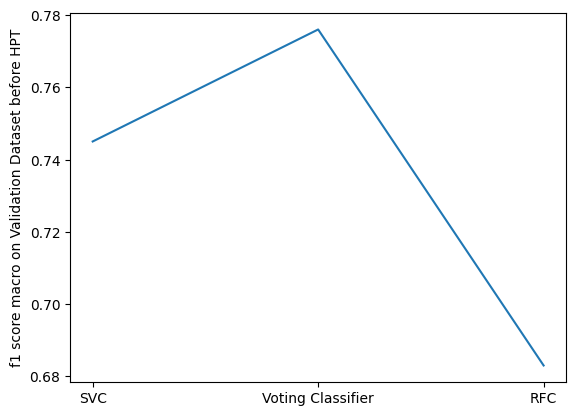

In [90]:
# Validation Score plot before Hyperparameter Tuning

before_HPT_validation_scores = [0.7450974435958877, 0.7762777617144094, 0.6831324234407025]

before_HPT_scores = [0.745, 0.776, 0.683] # scores are rounded upto 3 decimal places
model_names = ['SVC', 'Voting Classifier', 'RFC']

plt.plot(model_names, before_HPT_scores)
# plt.xlabel("model name")
plt.ylabel("f1 score macro on Validation Dataset before HPT")
plt.show()

## f1 macro score values for validation dataset after Hyperparameter Tuning:

**SVC Validation Score: 0.752**

**Voting Classifier Validation Score: 0.776**

**RFC Validation Score: 0.777**

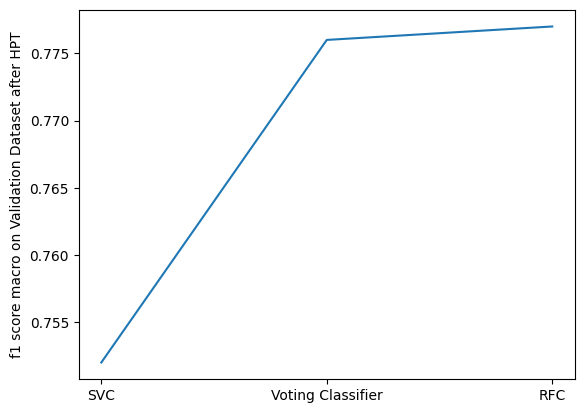

In [91]:
# Validation Score plot after Hyperparameter Tuning

after_HPT_validation_scores = [0.7520828723543569, 0.7762777617144094, 0.7769616581035266]

scores = [0.752, 0.776, 0.777] # scores are rounded upto 3 decimal places
model_names = ['SVC', 'Voting Classifier', 'RFC']

plt.plot(model_names, scores)
# plt.xlabel("model name")
plt.ylabel("f1 score macro on Validation Dataset after HPT")
plt.show()

## f1 macro score values for test data after Hyperparameter Tuning:

**SVC Test Score: 0.75308**

**Voting Classifier: 0.76946**

**RFC Test Score: 0.77012**

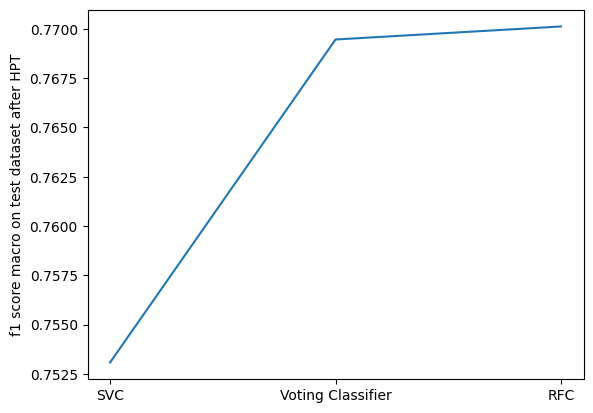

In [92]:
# Test Score plot after Hyperparameter Tuning

test_scores = [0.75308, 0.76946, 0.77012]
model_names = ['SVC', 'Voting Classifier', 'RFC']

plt.plot(model_names, test_scores)
# plt.xlabel("model name")
plt.ylabel("f1 score macro on test dataset after HPT")
plt.show()

#### As we can see from the above *three* graphs Hyperparameter Tuning has played a key role in the models' performances mainly for Random Forest Classifier alongside feature engineering

# Insights

## Model Performance Analysis

The dataset was evaluated using three classification models: **Support Vector Classifier (SVC)**, **Random Forest Classifier (RFC)**, and a **Voting Classifier** 

The **f1-macro score** was used as the primary metric for evaluation. Here are the scores for each model on **test dataset**:

- **SVC**: 0.75308
- **RFC**: 0.77012
- **Voting Classifier**: 0.76946

## Insights and Analysis

1. **Random Forest Classifier (RFC) Performance**:
   - The RFC achieved the highest f1-macro score at **0.77012**, indicating its strength in handling the dataset's structure and feature interactions. RFC’s ability to handle complex, nonlinear relationships likely contributed to this superior performance.
   - The RFC's ensemble nature (averaging multiple decision trees for regression problems & majority voting for classification problems) adds stability to its predictions, reducing overfitting risks, especially in datasets with diverse patterns.

2. **Support Vector Classifier (SVC) Performance**:
   - The SVC performed moderately well with an f1-macro score of **0.75308**. This score suggests that SVC can generalize decently but may struggle with more complex relationships due to its reliance on a margin-based classification.
   - SVC is generally effective when clear class boundaries exist, but the lower score compared to RFC suggests it might not be capturing some of the subtle patterns that RFC could.

3. **Voting Classifier Performance**:
   - The Voting Classifier, which combines predictions from SVC, MLPClassifier and RFC, resulted in an f1-macro score of **0.76946**. This performance, however, was slightly lower than the individual RFC model.

## Conclusion

- **RFC** appears to be the best choice for this dataset, given its strong score and ability to handle complex relationships within the data.

In [93]:
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import f1_score
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as imbpipeline
# import pandas as pd
# import numpy as np


# # Load the train and test datasets
# train = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
# test = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

# # Show the first few rows of the train dataset to understand its structure
# train.head()

In [94]:
# # Step 1: Handle Date Column
# train['last contact date'] = pd.to_datetime(train['last contact date'], errors='coerce')
# test['last contact date'] = pd.to_datetime(test['last contact date'], errors='coerce')

# # Extract new features from date column (Feature Engineering)
# train['contact_year'] = train['last contact date'].dt.year
# train['contact_month'] = train['last contact date'].dt.month
# train['contact_day'] = train['last contact date'].dt.day

# # added two new columns from the extracted data
# train['day_name'] = train['last contact date'].dt.day_name()
# train['month_name'] = train['last contact date'].dt.month_name()

# test['contact_year'] = test['last contact date'].dt.year
# test['contact_month'] = test['last contact date'].dt.month
# test['contact_day'] = test['last contact date'].dt.day

# # similar to train dataset here also added two new columns from the extracted data
# test['day_name'] = test['last contact date'].dt.day_name()
# test['month_name'] = test['last contact date'].dt.month_name()

# # # Add a new feature 'is_weekend' based on 'day_name'
# # train['is_weekend'] = train['day_name'].isin(['Friday', 'Saturday', 'Sunday'])
# # test['is_weekend'] = test['day_name'].isin(['Friday', 'Saturday', 'Sunday'])

# # Drop the original 'last contact date' column
# train.drop('last contact date', axis=1, inplace=True)
# test.drop('last contact date', axis=1, inplace=True)

In [95]:
# train.head()

In [96]:
# test.head()

In [97]:
# # Apply one-hot encoding for categorical features

# X = train.drop(columns=['target'])
# y = train[['target']]

# X_encoded = pd.get_dummies(X, drop_first=True)
# X_test = pd.get_dummies(test, drop_first=True)

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# # Check new class distribution
# print(y_resampled.value_counts())

In [98]:
# X_resampled = X_resampled.replace({True: 1, False: 0})
# X_test = X_test.replace({True: 1, False: 0})

# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42, stratify=y_resampled, shuffle=True)

# num = list(X_train.select_dtypes(include = "int").columns)
# cat = list(X_train.select_dtypes(exclude = "int").columns)
# print(f"Numerical: {num}")
# print(f"Categorical: {cat}")

In [99]:
# X_test.columns

In [100]:
# scale = Pipeline(steps = [
#     ("std", StandardScaler())
# ])

# mode_ohe = Pipeline(steps = [
#     ("mode", SimpleImputer(strategy = "most_frequent")),
#     ("ohe", OneHotEncoder(sparse_output = False, handle_unknown='ignore'))
# ])

# mode_ordinal = Pipeline(steps = [('mode',SimpleImputer(strategy = 'most_frequent')),
#                        ('ordinal', OrdinalEncoder(categories = [['primary', 'secondary', 'tertiary']],
#                                                   handle_unknown='use_encoded_value', unknown_value=-1))])

# ct = ColumnTransformer(transformers = [
#     ("scale", scale, num),
#     ("mode_ohe", mode_ohe, cat)
#     # ("mode_ordinal", mode_ordinal, ['education_secondary', 'education_tertiary'])
# ],remainder = "passthrough").set_output(transform = "pandas")

# ct

In [101]:
# X_train_df = ct.fit_transform(X_train)
# X_val_df = ct.transform(X_val)
# X_test_df = ct.transform(X_test)

In [102]:
# rfc = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4, 
#                              n_estimators=500,random_state=42, oob_score=True,max_depth=None)
# rfc.fit(X_train_df, y_train)
# y_pred_rfc = rfc.predict(X_val_df)
# score_rfc = f1_score(y_val, y_pred_rfc, average = "macro", pos_label = 1)
# print(f"f1_score for RandomForestClassifier: {score_rfc}")

In [103]:
# y_pred_rfc

In [104]:
# test_pred = rfc.predict(X_test_df)
# test_pred

In [105]:
# from sklearn.feature_selection import RFE

# rfe = RFE(estimator = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4, 
#                                              n_estimators=500,random_state=42), 
#           n_features_to_select=None, step=1, verbose=3, importance_getter='auto')

# rfe.fit(X_train_df, y_train)

# selected = rfe.support_
# print(selected)

# new_train_processed = X_train_df[X_train_df.columns[selected]]
# # new_train_processed.head()

# classifier = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4, 
#                                              n_estimators=500,random_state=42)

# classifier.fit(new_train_processed, y_train)
# pred = classifier.predict(X_val_df[X_val_df.columns[selected]])
# print(f"f1 macro score: {f1_score(y_val, pred, average='macro', labels='yes', pos_label=1)}")

In [106]:
# print(classification_report(y_val, pred))

In [107]:
# print(confusion_matrix(y_val, pred))

In [108]:
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_predictions(y_val, pred)

In [109]:
# # classifier definition
# clf1 = SVC(C=0.1, class_weight='balanced', degree=4, gamma='auto',
#            probability=True, random_state=42, verbose=True)
# clf2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
#                        n_estimators=500, oob_score=True, random_state=42, verbose=3)
# clf3 = MLPClassifier(hidden_layer_sizes=(300,150), activation='tanh',
#                     solver='adam', alpha=0.0001, learning_rate='adaptive',
#                     learning_rate_init=1e-2, max_iter=1000, shuffle=True,
#                     random_state=42, tol=1e-3, verbose=True, warm_start=True,
#                     early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000)

# # voting classifier definition for hard voting
# logit = VotingClassifier(estimators=[
#         ('svc', clf1), ('rf', clf2), ('mlp', clf3)], voting='hard')

# logit.fit(new_train_processed, y_train)

# logit_val_pred = logit.predict(X_val_df[X_val_df.columns[selected]])
# print(f"\n Validation Prediction: {logit_val_pred}")
# print(f"f1 score for Logistic Regression is {f1_score(y_val, logit_val_pred, average='macro', labels='yes', pos_label=1)}")
# logit_test_pred = logit.predict(X_test_df[X_test_df.columns[selected]])
# print(f"\n Test Prediction: {logit_test_pred}")

In [110]:
# rfe_pred_y = logit.predict(X_test_df[X_test_df.columns[selected]])
# print(rfe_pred_y)

In [111]:
# # submission CSV file generation

# submission = pd.DataFrame({"id": range(len(rfe_pred_y)),
#                                 "target": rfe_pred_y})

# submission.to_csv("submission.csv", index = False)

# New Best Model For Final Submission

In [112]:
# Load the data
train_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

# Data Preprocessing
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'])
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'])

# Extract features from 'last contact date'
for df in [train_df, test_df]:
    df['contact_year'] = df['last contact date'].dt.year
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_day'] = df['last contact date'].dt.day
    df['contact_dayofweek'] = df['last contact date'].dt.dayofweek
    df.drop('last contact date', axis=1, inplace=True)

# Handle missing values
for col in ['job', 'education', 'contact', 'poutcome']:
    train_df[col] = train_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

# Encode categorical variables using one-hot encoding
train_df_encoded = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'default', 
                                                     'housing', 'loan', 'contact', 'poutcome'])
test_df_encoded = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'default', 
                                                   'housing', 'loan', 'contact', 'poutcome'])

# Align test data to train columns
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)

# Separate features and target variable
X = train_df_encoded.drop('target', axis=1)
y = train_df_encoded['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_test = test_df_encoded.drop('target', axis=1)

# Polynomial Features with reduced complexity
poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Handle class imbalance with SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, 
                                                      test_size=0.2, random_state=42)

# Define parameter distributions with reduced ranges for faster tuning
param_dist_rf = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': sp_randint(5, 15),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 3)
}

param_dist_xgb = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': sp_randint(5, 15),
    'learning_rate': sp_uniform(0.01, 0.1),
    'subsample': sp_uniform(0.7, 0.3),
    'colsample_bytree': sp_uniform(0.7, 0.3)
}

param_dist_lgbm = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': sp_randint(5, 15),
    'learning_rate': sp_uniform(0.01, 0.1),
    'subsample': sp_uniform(0.7, 0.3)
}

# Initialize models with faster tuning
rfc = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Faster RandomizedSearchCV with fewer iterations and a smaller subset for tuning
random_search_rfc = RandomizedSearchCV(rfc, param_distributions=param_dist_rf, n_iter=20, 
                                       cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, 
                                       random_state=42)
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=20, 
                                       cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, 
                                       random_state=42)
random_search_lgbm = RandomizedSearchCV(lgbm, param_distributions=param_dist_lgbm, n_iter=20, 
                                        cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, 
                                        random_state=42)

# Fit the random searches with reduced data for speed
# random_search_rfc.fit(X_train[:30000], y_train[:30000])
# random_search_xgb.fit(X_train[:30000], y_train[:30000])
# random_search_lgbm.fit(X_train[:30000], y_train[:30000])

random_search_rfc.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_lgbm.fit(X_train, y_train)

# Best estimators
best_rfc = random_search_rfc.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_lgbm = random_search_lgbm.best_estimator_

# Voting Classifier with soft voting
voting_clf = VotingClassifier(estimators=[('rfc', best_rfc), ('xgb', best_xgb), ('lgbm', best_lgbm)], 
                              voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)

# Evaluate models with threshold tuning
def find_best_threshold(y_true, y_pred_probs):
    thresholds = np.arange(0.4, 0.6, 0.05)  # Smaller range for faster threshold tuning
    best_f1, best_threshold = 0, 0.5
    for threshold in thresholds:
        preds = (y_pred_probs[:, 1] >= threshold).astype(int)
        score = f1_score(y_true, preds, average='macro')
        if score > best_f1:
            best_f1, best_threshold = score, threshold
    return best_f1, best_threshold

# Voting Classifier predictions on validation set
voting_probs = voting_clf.predict_proba(X_valid)
best_f1, best_threshold = find_best_threshold(y_valid, voting_probs)
voting_pred = (voting_probs[:, 1] >= best_threshold).astype(int)

print(f"Voting Classifier Best F1 Score (Tuned Threshold): {best_f1}")
print(f"Optimal Threshold for Voting Classifier: {best_threshold}")

# Predict on the test set using optimal threshold
test_probs = voting_clf.predict_proba(X_test_scaled)
test_predictions = (test_probs[:, 1] >= best_threshold).astype(int)

# Convert predictions back to original labels
test_predictions = ['yes' if pred == 1 else 'no' for pred in test_predictions]

# Create submission file
submission_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
submission_df['target'] = test_predictions
submission_df.to_csv('submission.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 16484, number of negative: 13148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556290 -> initscore=0.226121
[LightGBM] [Info] Start training from score 0.226121
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you did

In [113]:
print(f"Voting Classifier Best F1 Score (Tuned Threshold): {best_f1}")
print(f"Optimal Threshold for Voting Classifier: {best_threshold}")

Voting Classifier Best F1 Score (Tuned Threshold): 0.9697481029095084
Optimal Threshold for Voting Classifier: 0.55


In [114]:
best_rfc = random_search_rfc.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_lgbm = random_search_lgbm.best_estimator_

print(f"best_rfc: {best_rfc}")
print(f"\n best_xgb: {best_xgb}")
print(f"\n best_lgbm: {best_lgbm}")

best_rfc: RandomForestClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=109, n_jobs=-1, random_state=42)

 best_xgb: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7069187275124247, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06247746602583892,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=141, n_jobs=-1,
              num_parallel_tree=None, random

best_rfc: RandomForestClassifier(class_weight='balanced', max_depth=13,
                       min_samples_split=4, n_estimators=108, n_jobs=-1,
                       random_state=42)

 best_xgb: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9908753883293675, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08751328233611146,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=123, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

 best_lgbm: LGBMClassifier(learning_rate=0.08553614103176525, max_depth=10,
               n_estimators=103, n_jobs=-1, random_state=42,
               subsample=0.8640130838029838)